- Both saliency maps and class activation maps are visualization techniques used in deep learning to help understand which parts of an input image are most important for a neural network to make its prediction. However, there are some key differences between the two techniques.

- A saliency map is a heatmap that highlights the regions of an input image that have the strongest influence on the output of a neural network. It is generated by computing the gradients of the output with respect to the input image, and using the absolute value of the gradients as the saliency map. The intuition behind this approach is that areas of the input image with high gradients are more important for the network's prediction. Saliency maps are typically used for visualizing the contribution of individual pixels or small regions of an image to the network's output.

- On the other hand, a class activation map (CAM) is a heatmap that shows which regions of an input image were most important for a neural network to make a particular prediction. CAMs are generated by analyzing the feature maps of the last convolutional layer of a neural network and projecting them back onto the input image. The resulting heatmap shows which regions of the image were most strongly activated by the final convolutional layer, and therefore which regions were most important for the network to make its prediction. CAMs are typically used for visualizing the contribution of larger regions or objects in an image to the network's output.

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# grab the model from Tensorflow hub and append a softmax activation
model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'),
    tf.keras.layers.Activation('softmax')
])

In [6]:
# build the model based on a specified batch input shape
model.build([None, 300, 300, 3])

In [7]:
# read the image
img = cv2.imread('image.jpg')

# format it to be in the RGB colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

# resize to 300x300 and normalize pixel values to be in the range [0, 1]
img = cv2.resize(img, (300, 300)) / 255.0

# add a batch dimension in front
image = np.expand_dims(img, axis=0)

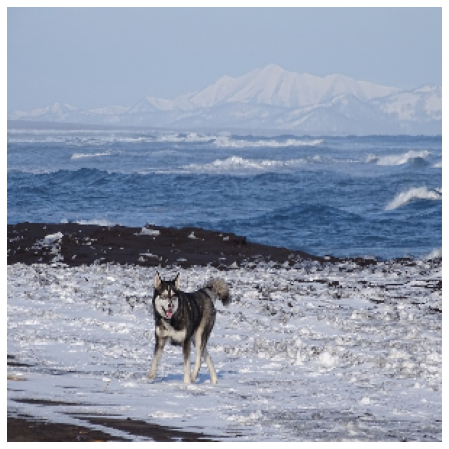

In [8]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [21]:
## Siberian Husky's Class ID in ImageNet
class_index=251

# number of classes in the model's training data
num_classes=1001
print(image.shape)
expected_output=tf.one_hot([class_index]*image.shape[0],num_classes)
print(f'Expected output {expected_output.shape}')

(1, 300, 300, 3)
Expected output (1, 1001)


In [12]:
with tf.GradientTape() as tape:
    inputs=tf.cast(image,tf.float32)
    
    tape.watch(inputs)
    
    prediction=model(inputs)
    
    loss=tf.keras.losses.categorical_crossentropy(
    expected_output,prediction)
    
    
gradients=tape.gradient(loss,inputs)


In [14]:
# reduce the RGB image to grayscale
grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

# normalize the pixel values to be in the range [0, 255].
# the max value in the grayscale tensor will be pushed to 255.
# the min value will be pushed to 0.
normalized_tensor = tf.cast(
    255
    * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
    / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
    tf.uint8,
)

# remove the channel dimension to make the tensor a 2d tensor
normalized_tensor = tf.squeeze(normalized_tensor)

numpy.unravel_index() function converts a flat index or array of flat indices into a tuple of coordinate arrays.

- Syntax : numpy.unravel_index(indices, shape, order = ‘C’)
- Parameters :
    - indices : [array_like] An integer array whose elements are indices into the flattened version of an array of dimensions shape.
    - shape : [tuple of ints] The shape of the array to use for unraveling indices.
    - order : [{‘C’, ‘F’}, optional] Determines whether the multi-index should be viewed as indexing in row-major (C-style) or - column-major (Fortran-style) order.

Return : [tuple of ndarray] Each array in the tuple has the same shape as the indices array.

In [15]:
# max and min value in the grayscale tensor
print(np.max(grayscale_tensor[0]))
print(np.min(grayscale_tensor[0]))
print()

# coordinates of the first pixel where the max and min values are located
max_pixel = np.unravel_index(np.argmax(grayscale_tensor[0]), grayscale_tensor[0].shape)
min_pixel = np.unravel_index(np.argmin(grayscale_tensor[0]), grayscale_tensor[0].shape)
print(max_pixel)
print(min_pixel)
print()

# these coordinates should have the max (255) and min (0) value in the normalized tensor
print(normalized_tensor[max_pixel])
print(normalized_tensor[min_pixel])

1.0859438
0.0

(207, 132)
(0, 299)

tf.Tensor(255, shape=(), dtype=uint8)
tf.Tensor(0, shape=(), dtype=uint8)


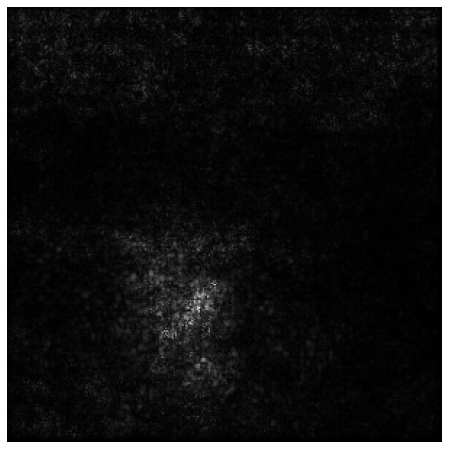

In [16]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor, cmap='gray')
plt.show()

Let's superimpose the normalized tensor to the input image to get more context. You can see that the strong pixels are over the husky and that is a good indication that the model is looking at the correct part of the image.

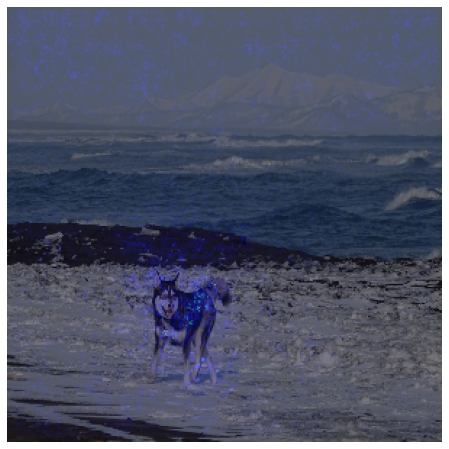

In [17]:
gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
gradient_color = gradient_color / 255.0
super_imposed = cv2.addWeighted(img, 0.5, gradient_color, 0.5, 0.0)

plt.figure(figsize=(8, 8))
plt.imshow(super_imposed)
plt.axis('off')
plt.show()

### cv2.addWeighted(src1, alpha, src2, beta,y)
Here src1 is the path for the first image and scr2 is the path for the second image.  The alpha and beta are the constant or weight for the first and second image respectively. The “y”  is some constant. The above function follows the below equation.

cv2 addwighted euqation

In [24]:
%%latex

$$image=alpha*src1+Beta*src2+y$$

<IPython.core.display.Latex object>